In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class GalaxyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Store all labels for sampling weights calculation
        self.labels = []
        for img_name in self.image_files:
            label_str = img_name.split('_')[-1].split('.')[0]
            self.labels.append(int(label_str))
        
        # Calculate class weights
        label_counter = Counter(self.labels)
        self.class_weights = {cls: 1.0/count for cls, count in label_counter.items()}
        
        # Store sample weights for WeightedRandomSampler
        self.sample_weights = [self.class_weights[label] for label in self.labels]
        self.sample_weights = torch.FloatTensor(self.sample_weights)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        label = self.labels[idx]
        
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        image = image.resize((128, 128))
        
        # Data augmentation for training
        if torch.rand(1) > 0.5:  # Random horizontal flip
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Convert to numpy array and normalize
        image_array = np.array(image) / 255.0
        
        # Convert to tensor
        image_tensor = torch.FloatTensor(image_array).permute(2, 0, 1)
        
        return image_tensor, label

In [4]:
# Dataset path
data_dir = os.path.expanduser("~/Desktop/BE Project/Decals_data_images")

# Create dataset
dataset = GalaxyDataset(root_dir=data_dir)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import torch
import torch.nn as nn

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes):
        super(GalaxyCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(512 * 8 * 8, 2048),  # Smaller first dense layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.01):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_acc = 0.0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            progress_bar.set_postfix({'loss': running_loss / len(train_loader), 'accuracy': 100. * correct / total})
        
        train_losses.append(running_loss / len(train_loader))
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}: Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        scheduler.step(val_accuracy)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    plot_loss(train_losses, val_losses)

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.show()

def evaluate_model(model, loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4))

    return accuracy


c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30: 100%|██████████| 444/444 [01:44<00:00,  4.23it/s, loss=2.17, accuracy=19.3] 



Epoch 1/30: Validation Loss: 2.3032, Accuracy: 17.45%


Epoch 2/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=1.9, accuracy=27.9]  



Epoch 2/30: Validation Loss: 2.5442, Accuracy: 16.46%
EarlyStopping counter: 1 out of 5


Epoch 3/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=1.67, accuracy=36.8] 



Epoch 3/30: Validation Loss: 1.7182, Accuracy: 39.63%


Epoch 4/30: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s, loss=1.55, accuracy=41.3] 



Epoch 4/30: Validation Loss: 1.5143, Accuracy: 42.76%


Epoch 5/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=1.45, accuracy=46.3] 



Epoch 5/30: Validation Loss: 2.5580, Accuracy: 24.66%
EarlyStopping counter: 1 out of 5


Epoch 6/30: 100%|██████████| 444/444 [01:30<00:00,  4.93it/s, loss=1.32, accuracy=51.2] 



Epoch 6/30: Validation Loss: 1.2393, Accuracy: 54.11%


Epoch 7/30: 100%|██████████| 444/444 [01:30<00:00,  4.91it/s, loss=1.24, accuracy=56]   



Epoch 7/30: Validation Loss: 2.2428, Accuracy: 29.31%
EarlyStopping counter: 1 out of 5


Epoch 8/30: 100%|██████████| 444/444 [01:29<00:00,  4.95it/s, loss=1.15, accuracy=60.1] 



Epoch 8/30: Validation Loss: 1.1231, Accuracy: 60.79%


Epoch 9/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=1.06, accuracy=63.7] 



Epoch 9/30: Validation Loss: 0.9510, Accuracy: 67.95%


Epoch 10/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.997, accuracy=65.5]



Epoch 10/30: Validation Loss: 1.0151, Accuracy: 66.01%
EarlyStopping counter: 1 out of 5


Epoch 11/30: 100%|██████████| 444/444 [01:29<00:00,  4.96it/s, loss=0.951, accuracy=67.4]



Epoch 11/30: Validation Loss: 1.0259, Accuracy: 64.99%
EarlyStopping counter: 2 out of 5


Epoch 12/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.907, accuracy=68.6]



Epoch 12/30: Validation Loss: 0.9646, Accuracy: 66.69%
EarlyStopping counter: 3 out of 5


Epoch 13/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.852, accuracy=70.1]



Epoch 13/30: Validation Loss: 0.8240, Accuracy: 72.13%


Epoch 14/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.811, accuracy=72.3]



Epoch 14/30: Validation Loss: 0.8165, Accuracy: 73.14%


Epoch 15/30: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s, loss=0.783, accuracy=73]   



Epoch 15/30: Validation Loss: 0.8892, Accuracy: 70.12%
EarlyStopping counter: 1 out of 5


Epoch 16/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.756, accuracy=74]  



Epoch 16/30: Validation Loss: 0.9245, Accuracy: 67.53%
EarlyStopping counter: 2 out of 5


Epoch 17/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.743, accuracy=74.3]



Epoch 17/30: Validation Loss: 0.8133, Accuracy: 73.22%


Epoch 18/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.698, accuracy=76.3]



Epoch 18/30: Validation Loss: 0.7965, Accuracy: 72.18%


Epoch 19/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.665, accuracy=76.6]



Epoch 19/30: Validation Loss: 0.8948, Accuracy: 70.01%
EarlyStopping counter: 1 out of 5


Epoch 20/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.651, accuracy=77.5]



Epoch 20/30: Validation Loss: 0.8268, Accuracy: 74.32%
EarlyStopping counter: 2 out of 5


Epoch 21/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.653, accuracy=77.3]



Epoch 21/30: Validation Loss: 0.9041, Accuracy: 72.07%
EarlyStopping counter: 3 out of 5


Epoch 22/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.612, accuracy=79]  



Epoch 22/30: Validation Loss: 0.7756, Accuracy: 75.31%


Epoch 23/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.602, accuracy=79.1]



Epoch 23/30: Validation Loss: 0.8479, Accuracy: 71.65%
EarlyStopping counter: 1 out of 5


Epoch 24/30: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s, loss=0.562, accuracy=80.1]



Epoch 24/30: Validation Loss: 0.7810, Accuracy: 74.52%


Epoch 25/30: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s, loss=0.537, accuracy=81.2]



Epoch 25/30: Validation Loss: 0.7480, Accuracy: 76.32%


Epoch 26/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.522, accuracy=81.6]



Epoch 26/30: Validation Loss: 0.9690, Accuracy: 68.29%
EarlyStopping counter: 1 out of 5


Epoch 27/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.511, accuracy=82]   



Epoch 27/30: Validation Loss: 0.8139, Accuracy: 73.96%
EarlyStopping counter: 2 out of 5


Epoch 28/30: 100%|██████████| 444/444 [01:29<00:00,  4.99it/s, loss=0.489, accuracy=82.7]



Epoch 28/30: Validation Loss: 1.0951, Accuracy: 68.43%
EarlyStopping counter: 3 out of 5


Epoch 29/30: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s, loss=0.469, accuracy=83.2]



Epoch 29/30: Validation Loss: 0.8196, Accuracy: 74.04%
EarlyStopping counter: 4 out of 5


Epoch 30/30: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s, loss=0.362, accuracy=87.2] 



Epoch 30/30: Validation Loss: 0.7677, Accuracy: 78.38%
EarlyStopping counter: 5 out of 5
Early stopping triggered


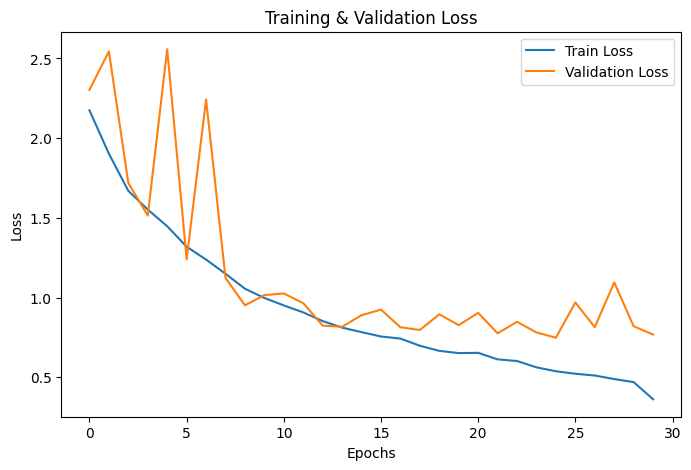

Evaluating: 100%|██████████| 111/111 [00:13<00:00,  7.97it/s]


Accuracy: 77.96%


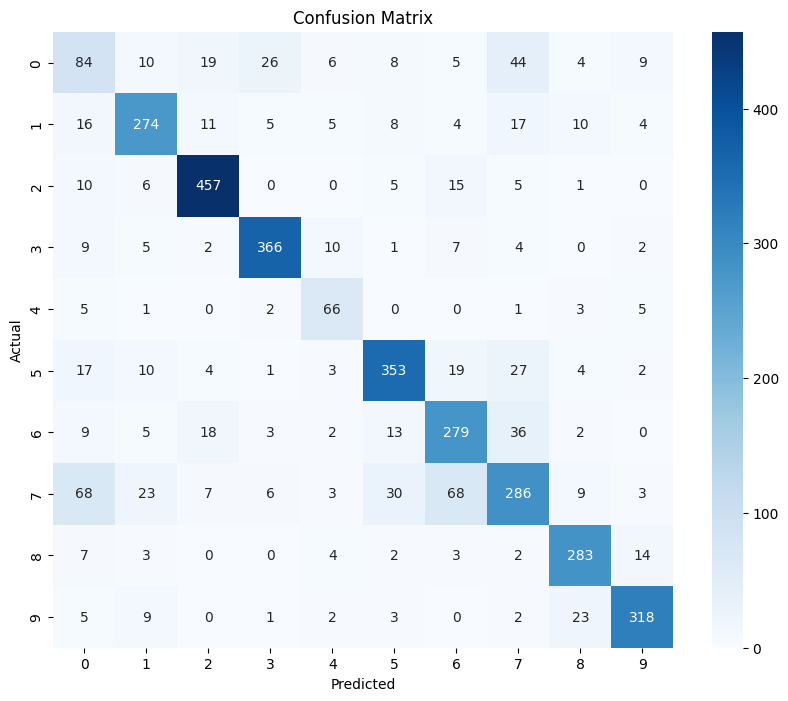


Classification Report:
               precision    recall  f1-score   support

           0     0.3652    0.3907    0.3775       215
           1     0.7919    0.7740    0.7829       354
           2     0.8822    0.9158    0.8987       499
           3     0.8927    0.9015    0.8971       406
           4     0.6535    0.7952    0.7174        83
           5     0.8345    0.8023    0.8181       440
           6     0.6975    0.7602    0.7275       367
           7     0.6745    0.5686    0.6170       503
           8     0.8348    0.8899    0.8615       318
           9     0.8908    0.8760    0.8833       363

    accuracy                         0.7796      3548
   macro avg     0.7518    0.7674    0.7581      3548
weighted avg     0.7799    0.7796    0.7786      3548

Model saved successfully!


In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyCNN(num_classes=10).to(device)

class_weights = torch.FloatTensor([1.0/1081, 1.0/1853, 1.0/2645, 1.0/2027, 1.0/334, 1.0/2043, 1.0/1829, 1.0/2628, 1.0/1423, 1.0/1873]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True, min_lr=1e-6)

num_epochs = 30
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs)
evaluate_model(model, val_loader)
torch.save(model.state_dict(), "galaxy_cnn_balanced.pth")
print("Model saved successfully!")


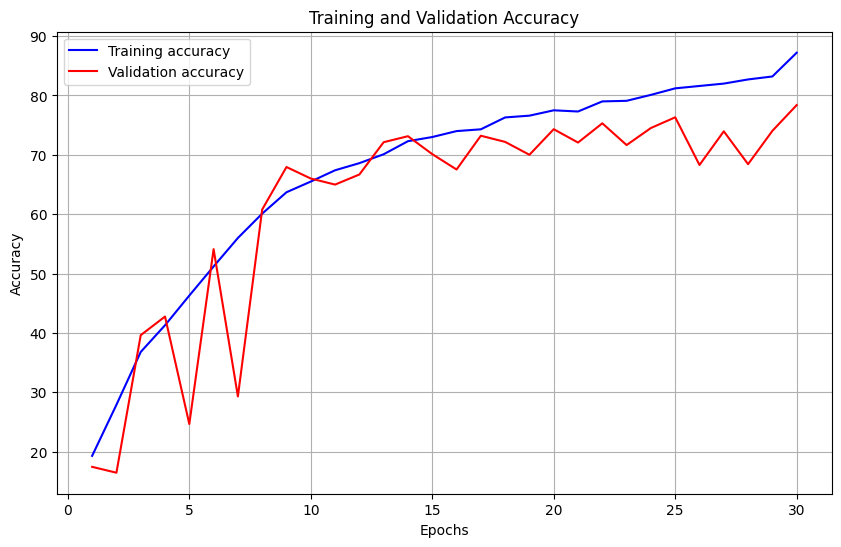

In [9]:
import matplotlib.pyplot as plt

# Training and validation accuracies for each epoch
train_accuracies = [
    19.3, 27.9, 36.8, 41.3, 46.3, 51.2, 56.0, 60.1, 63.7, 65.5,
    67.4, 68.6, 70.1, 72.3, 73.0, 74.0, 74.3, 76.3, 76.6, 77.5,
    77.3, 79.0, 79.1, 80.1, 81.2, 81.6, 82.0, 82.7, 83.2, 87.2
]
val_accuracies = [
    17.45, 16.46, 39.63, 42.76, 24.66, 54.11, 29.31, 60.79, 67.95, 66.01,
    64.99, 66.69, 72.13, 73.14, 70.12, 67.53, 73.22, 72.18, 70.01, 74.32,
    72.07, 75.31, 71.65, 74.52, 76.32, 68.29, 73.96, 68.43, 74.04, 78.38
]
epochs = range(1, 31)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
